## SetUp

In [1]:
# install required dependencies
!pip install -qq transformers
!pip install -qq datasets
!pip install -qq umap-learn

     |████████████████████████████████| 4.7 MB 8.4 MB/s 
     |████████████████████████████████| 596 kB 66.3 MB/s 
     |████████████████████████████████| 6.6 MB 50.0 MB/s 
     |████████████████████████████████| 101 kB 13.5 MB/s 
     |████████████████████████████████| 365 kB 7.0 MB/s 
     |████████████████████████████████| 1.1 MB 59.1 MB/s 
     |████████████████████████████████| 140 kB 72.6 MB/s 
     |████████████████████████████████| 212 kB 65.6 MB/s 
     |████████████████████████████████| 127 kB 75.8 MB/s 
     |████████████████████████████████| 271 kB 65.4 MB/s 
     |████████████████████████████████| 94 kB 3.1 MB/s 
     |████████████████████████████████| 144 kB 77.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 8

In [2]:
# import the necessary libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

### Loading Data

* the data is stored [here](https://raw.githubusercontent.com/chimaobi-okite/NLP-Projects-Competitions/main/NewsCategorization/Data/), and will be loaded as a hugging face dataset
* Load the data and generate validation split from the the train split

In [3]:
train_url = 'https://raw.githubusercontent.com/chimaobi-okite/NLP-Projects-Competitions/main/NewsCategorization/Data/train.csv'
test_url = 'https://raw.githubusercontent.com/chimaobi-okite/NLP-Projects-Competitions/main/NewsCategorization/Data/test.csv'

In [4]:
dataset = load_dataset('csv', data_files={'train': train_url,'test': test_url})

Using custom data configuration default-95021031e81fcec6


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-95021031e81fcec6/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
# split the train data to training and validation set
dataset_ = dataset["train"].train_test_split(train_size=0.85, seed=42) # initialize new dataset with train of old dataset
dataset['train'] = dataset_.pop('train') # override the train of datset with the new train
dataset['validation'] = dataset_.pop('test') # include a validation data to dataset
dataset  # view result

DatasetDict({
    train: Dataset({
        features: ['Title', 'Excerpt', 'Category', 'labels'],
        num_rows: 3904
    })
    test: Dataset({
        features: ['Title', 'Excerpt', 'Category', 'labels'],
        num_rows: 811
    })
    validation: Dataset({
        features: ['Title', 'Excerpt', 'Category', 'labels'],
        num_rows: 690
    })
})

## Expository Data Analysis

In [6]:
dataset.set_format(type='pandas')
df = dataset['train'][:]
df.head()

,Title,Excerpt,Category,labels
0,Nigeria: APC Yet to Zone Party Positions Ahead...,The leadership of the All Progressives Congres...,politics,2
1,Facebook Unveils New Controls for Kids Using I...,"Facebook, in the aftermath of damning testimon...",tech,5
2,French Open: Djokovic Outlasts Tsitsipas for 1...,Novak Djokovic won his 19th Grand Slam title a...,sports,4
3,Seven Lawmakers Arrested in Hong Kong,Seven pro-democratic lawmakers were arrested i...,politics,2
4,Unai Emery Rules Himself out of Newcastle Unit...,Unai Emery has ruled himself out of contention...,sports,4


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


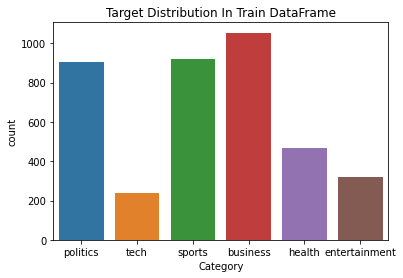

In [7]:
ax = sns.countplot('Category', data = df)
# for p in ax.patches:
#   size = df.shape[0]
#   x, y = p.get_x() , p.get_y()
#   height, width  = p.get_height(), p.get_width()
#   ax.annotate((x+width, height), '23')
plt.title('Target Distribution In Train DataFrame')
plt.show()

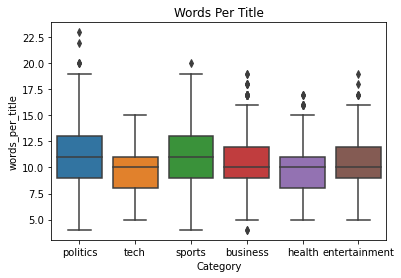

In [8]:
## see word cound distribution in title column
df['words_per_title'] = df['Title'].map(lambda x : len(str(x).split()))
sns.boxplot(y = 'words_per_title', x = 'Category', data = df)
plt.title('Words Per Title')
plt.show()

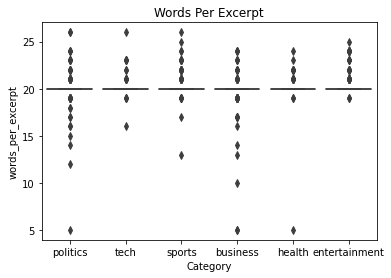

In [9]:
## see word cound distribution in Excerpt column
df['words_per_excerpt'] = df['Excerpt'].map(lambda x : len(str(x).split()))
sns.boxplot(y = 'words_per_excerpt', x = 'Category', data = df)
plt.title('Words Per Excerpt')
plt.show()

### Insights from EDA

* We can see that the dataset is Imbalanced with most news around business and politics and just few for tech and sports. This might be due to the fact that most Nigerians are more interested in politics, business and health.

* We can easily concatenate the title and excerpt column to a new column news without overshooting the number of words. So the models should be able to learn from this new column.

## Data Preparation For Modelling

* Reset data format
* Join the Title and Excerpt Columns
* Tokenize data
* Convert data to pytorch tensors

In [10]:
dataset.reset_format()

In [11]:
from transformers import AutoTokenizer

In [12]:
# define model checkpoint
model_ckpt = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [13]:
sample_text = dataset['train']['Title'][0] + '.' + dataset['train']['Excerpt'][0]
sample_text

'Nigeria: APC Yet to Zone Party Positions Ahead of Convention.The leadership of the All Progressives Congress (APC), has denied reports that it had zoned some party positions ahead of'

In [14]:
tokenizer(sample_text)

{'input_ids': [0, 487, 1023, 6971, 35, 1480, 347, 3507, 7, 10351, 1643, 22464, 8237, 15396, 9, 9127, 4, 133, 1673, 9, 5, 404, 11679, 3699, 1148, 36, 591, 347, 238, 34, 2296, 690, 14, 24, 56, 992, 11469, 103, 537, 2452, 789, 9, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [15]:
# concat title and excerpt columns
def concat_news(batch):
  return {'News' :str(batch['Title']) + '.' + str(batch['Excerpt'])} 

def tokenize(batch):
  return tokenizer(batch['News'], padding=True, truncation=True)

In [16]:
data = dataset.map(concat_news)
encoded_dataset =  data.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/3904 [00:00<?, ?ex/s]

  0%|          | 0/811 [00:00<?, ?ex/s]

  0%|          | 0/690 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [17]:
encoded_dataset.set_format('torch', columns = ['input_ids','attention_mask', 'labels']) # convert lists of required columns to tensors

In [18]:
# define dictionary mappings that maps labels to catgories and vice-versa
labels =['health','business', 'politics', 'entertainment', 'sports', 'tech']
index2cat = {idx:cat for idx, cat in enumerate(labels)}
cat2index = {cat: idx for idx, cat in enumerate(labels)}

## Modelling 

### Evaluating model performance

Functions to plot a models confusion matrix and print classifcation reports

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

In [20]:
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize='true')
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
  plt.title('Normalized confusion matrix')
  plt.show()

In [21]:
def int2str(x):
  return index2cat.get(x)

def print_classification_report(y_true, y_pred):
  vfunc = np.vectorize(int2str) # function maps numpy array integers to string arrays
  y_true = vfunc(y_true) 
  y_pred = vfunc(y_pred)
  print(f1_score(y_true, y_pred, average='weighted'))
  print(classification_report(y_true,y_pred))

### Using Transformers As Feature Extractor

* Extract hidden state from a hugging face model checkpoint
* Reduce the feature size of the hidden state features, plot results and check usefulness of extracted features for modelling
* Build a logistics regression model using hidden states as features
* Check performance
* iterate with other model checkpoints

In [22]:
from transformers import AutoModel 
import torch
from sklearn.linear_model import LogisticRegression
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
def extract_hidden_state(batch):
  batch =  {k:v.to(device) for k,v in batch.items()} # save batch to device
  with torch.no_grad():
    outputs = model(input_ids = batch['input_ids'], attention_mask = batch['attention_mask'])
  last_hidden_state = outputs.last_hidden_state[:, 0]
  return {'hidden_state' : last_hidden_state.cpu().numpy()}

In [25]:
dataset_hidden = encoded_dataset.map(extract_hidden_state, batched = True)

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [26]:
X_train = np.array(dataset_hidden['train']['hidden_state'])
X_valid = np.array(dataset_hidden['validation']['hidden_state'])
y_train = np.array(encoded_dataset['train']['labels'])
y_valid = np.array(encoded_dataset['validation']['labels'])
X_train.shape, X_valid.shape

((3904, 768), (690, 768))

In [27]:
X_scaled = MinMaxScaler().fit_transform(X_train)  # Scale features to [0,1] range
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled) # Initialize and fit UMAP
df_emb = pd.DataFrame(mapper.embedding_, columns=['X', 'Y']) # Create a DataFrame of 2D embeddings
df_emb["label"] = y_train
df_emb.head()

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


,X,Y,label
0,12.797377,13.565001,2
1,7.967042,8.352435,5
2,5.007325,11.517357,4
3,9.240470,11.463827,2
4,7.915254,12.466432,4


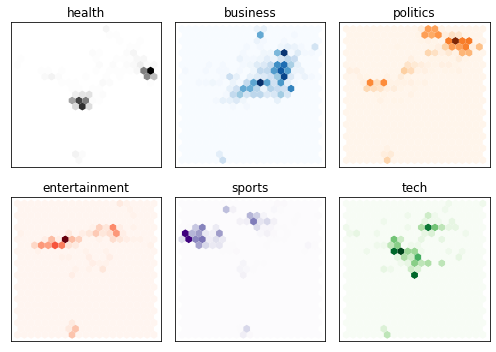

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ['Greys', 'Blues', 'Oranges', 'Reds', 'Purples', 'Greens']
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {i}")
  axes[i].hexbin(df_emb_sub['X'], df_emb_sub['Y'], cmap=cmap,
                 gridsize=20, linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()

We can see clear distinctions in the embeddings of the various model. It shows that our roberta-base model was able to extract useful features from the news dataset fed into it. We can also see an overlap between the feature space of business and tech which might be difficult for a claasification model to distinguish. Let us now train a simple logistics regression model to learn from this features and evaluate it on the validation data.

In [29]:
lr_clf = LogisticRegression(max_iter=3000, random_state = 42) # We increase `max_iter` to guarantee convergence
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000, random_state=42)

In [30]:
# see performance of logistics regression model
print_classification_report(y_true = y_valid, y_pred = lr_clf.predict(X_valid))

0.8685377797291672
               precision    recall  f1-score   support

     business       0.82      0.88      0.85       190
entertainment       0.85      0.91      0.88        45
       health       0.84      0.85      0.84        80
     politics       0.86      0.92      0.89       146
       sports       1.00      0.94      0.97       184
         tech       0.67      0.40      0.50        45

     accuracy                           0.87       690
    macro avg       0.84      0.82      0.82       690
 weighted avg       0.87      0.87      0.87       690



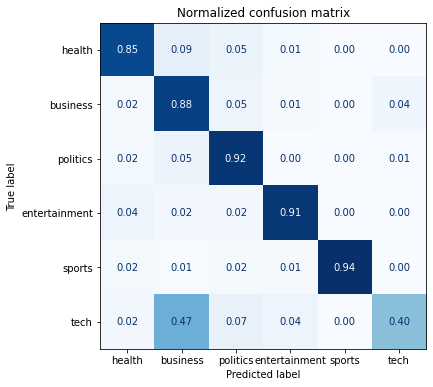

In [31]:
plot_confusion_matrix(lr_clf.predict(X_valid), y_valid, labels)

On iteration:
* with bert-base-uncased , f1_score = 85.67%
* with distilbert-uncased , f1_score = 87.84%
* with roberta-base-uncased , f1_score = 86.85%

Will use the roberta since it was pretrained on cnn_news + others which is similar with our news dataset

### Build Transformer For Text Classification

* Build custom transformer head for text classification
* Define a configuration file
* Test model on a sample text to ensure expected results
* Define a compution metric
* Train model and push to hub

In [32]:
import torch.nn as nn
from transformers import RobertaConfig
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

from transformers import TrainingArguments
from transformers import AutoConfig
from transformers import Trainer
from huggingface_hub import notebook_login

In [33]:
class RobertaForSequenceClassification(RobertaPreTrainedModel):

  config_class = RobertaConfig

  def __init__(self, config):
    super().__init__(config)
    self.num_labels = config.num_labels
    self.roberta = RobertaModel(config, add_pooling_layer=False)  # initialize roberta with no pooling layer
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    self.linear = nn.Linear(config.hidden_size, config.num_labels)
    self.init_weights()

  def forward(self, input_ids = None, attention_mask = None, token_type_ids=None, labels = None, **kwargs):
    outputs = self.roberta(input_ids=input_ids, attention_mask = attention_mask, 
                           token_type_ids = token_type_ids, **kwargs)
    sequence_outputs = self.dropout(outputs.last_hidden_state[:, 0])
    logits = self.linear(sequence_outputs)
    loss = None
    if labels is not None:
      loss_fct = nn.CrossEntropyLoss()
      loss = loss_fct(logits, labels)

    return SequenceClassifierOutput(loss = loss, logits = logits)


In [34]:
num_labels = 6 
config = AutoConfig.from_pretrained(model_ckpt,num_labels = num_labels, id2label=index2cat, label2id=cat2index) # initialiaze config file

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sequence_model = (RobertaForSequenceClassification.from_pretrained(model_ckpt, config=config)).to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['linear.bias', 'roberta.embeddings.po

In [36]:
# text model with sample news
inputs = torch.unsqueeze(torch.tensor(tokenizer(sample_text).input_ids),0).to(device)
attn_mask = torch.unsqueeze(torch.tensor(tokenizer(sample_text).attention_mask), 0).to(device)
label = torch.tensor([5]).to(device)

sequence_model(input_ids = inputs, attention_mask = attn_mask, labels = label)

SequenceClassifierOutput([('loss',
                           tensor(1.8582, device='cuda:0', grad_fn=<NllLossBackward0>)),
                          ('logits',
                           tensor([[-0.1216,  0.2260,  0.1787, -0.2289, -0.0284, -0.0590]],
                                  device='cuda:0', grad_fn=<AddmmBackward0>))])

Everything works fine. Time to actually finetune the custom model

In [37]:
# define a metric function
from sklearn.metrics import f1_score, accuracy_score
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [39]:
notebook_login() # login to hub

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [41]:
# define training argument
batch_size = 64
logging_steps = len(encoded_dataset['train'])/ batch_size
output_dir = f'{model_ckpt}-finetuned-news'
training_args = TrainingArguments(output_dir = output_dir, num_train_epochs=4,
                                per_device_train_batch_size=batch_size,per_device_eval_batch_size=batch_size,
                                weight_decay=0.01,evaluation_strategy="epoch",disable_tqdm=False,
                                logging_steps=logging_steps,push_to_hub=True,
                                log_level='error')

In [42]:
trainer = Trainer(model=sequence_model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset= encoded_dataset['train'],
                  eval_dataset= encoded_dataset['validation'],
                  tokenizer=tokenizer)
trainer.train();

Cloning https://huggingface.co/okite97/roberta-base-finetuned-news into local empty directory.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.520300,0.313809,0.895652,0.895930
2,0.204000,0.298103,0.898551,0.897710
3,0.138600,0.299139,0.902899,0.903450
4,0.100200,0.330217,0.902899,0.904812


#### Transformer Performance

In [43]:
## evaluate model on validation data
preds_output = trainer.predict(encoded_dataset['validation'])
y_preds = np.argmax(preds_output.predictions, axis = 1)
y_true = preds_output.label_ids

In [44]:
print_classification_report(y_true,y_preds)

0.9048118100621028
               precision    recall  f1-score   support

     business       0.86      0.85      0.85       190
entertainment       0.90      0.96      0.92        45
       health       0.92      0.91      0.92        80
     politics       0.95      0.90      0.93       146
       sports       1.00      0.98      0.99       184
         tech       0.59      0.71      0.65        45

     accuracy                           0.90       690
    macro avg       0.87      0.89      0.88       690
 weighted avg       0.91      0.90      0.90       690



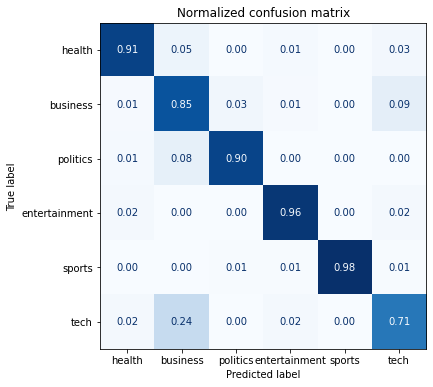

In [45]:
plot_confusion_matrix(y_preds, y_true, labels)

We can see a huge increase in performance from the previous model using transformer as feature extractor. The transformer model is able to now recognize 71% of all tech news unlike the logistics regression model that was able to recognize just 40%, also f1_score increased from 87% to 90%. To be sure the model works as expected, lets perform some error analysis

#### Error Analysis

In [46]:
from torch.nn.functional import cross_entropy
def forward_pass_with_label(batch):
  inputs = {k:v.to(device) for k,v in batch.items() if
           k in tokenizer.model_input_names}  # save inputs to same device as model
  with torch.no_grad():
    outputs = sequence_model(**inputs)
  pred_labels = torch.argmax(outputs.logits, axis = -1)
  loss = cross_entropy(outputs.logits, batch['labels'].to(device), reduction = 'none')
  return {'loss' : loss.cpu().numpy(),
          'predicted_label': pred_labels.cpu().numpy()}

In [47]:
encoded_dataset.set_format('torch', columns = ['input_ids', 'attention_mask', 'labels'])

In [48]:
validation_dataset = encoded_dataset['validation'].map(forward_pass_with_label, batched = True, batch_size = 16)

  0%|          | 0/44 [00:00<?, ?ba/s]

In [49]:
validation_dataset.set_format('pandas')  # set format for validation data to pandas
columns = ['News', 'labels', 'predicted_label','loss']
df_val = validation_dataset[:][columns] # use selected columns
df_val['labels'] = df_val['labels'].map(index2cat) # map labels index to category
df_val['predicted_label'] = df_val['predicted_label'].map(index2cat) # map predicted_labels to category

In [52]:
df_val.sort_values(by = 'loss', ascending = False).head(20)

,News,labels,predicted_label,loss
478,Russia and China Come Together on Covid.When R...,politics,health,8.426814
599,Canada Says AstraZeneca Vaccine Safe After Nor...,tech,health,8.179204
262,No Sense for Oil to be Cheaper in Nigeria than...,politics,business,7.732007
389,Nigeria: We Don’t Want President That Can Run ...,business,politics,6.806088
439,Rwandan President Kagame Wants To Build Africa...,business,health,6.642442
453,Biden Rejects New Republican Infrastructure Of...,business,politics,6.440972
143,Laporta Returns as Barcelona President after W...,sports,politics,5.816700
622,President Buhari Inaugurates 326km Nigerian Ra...,politics,business,5.813725
240,Bob Dylan Sells Entire Song Catalog to Univers...,business,entertainment,5.678846
668,"#EndSARS: Lewis Hamilton, Kerry Washington Spe...",sports,entertainment,5.643807


In [53]:
df_val.sort_values(by = 'loss', ascending = True).head(10)

,News,labels,predicted_label,loss
221,NNPC Pays $452.5m Cash Call Arrears to IOCs in...,business,business,0.000739
86,"AFEX Tops Agriculture, Commodities List in FT’...",business,business,0.000783
451,NNPC Reduces Cash-call Debts to IOCs by $3.11b...,business,business,0.000785
444,All Set for Zenith Bank’s 7th Annual Internati...,business,business,0.000789
192,Nigeria: NNPC Boss Kyari Calls for Transparenc...,business,business,0.000808
125,Ex-VP Atiku Says Zoning the Presidency Not the...,politics,politics,0.000822
265,Nigerian Business Magnate Tony Elumelu Laments...,business,business,0.000832
513,Nigeria: Picking a Southerner As Presidential ...,politics,politics,0.000833
66,Fresh Concerns in Nigeria as Crude Oil Price S...,business,business,0.000840
496,"‘Leader, Brother, Friend’: You Truly Belong to...",politics,politics,0.000842


##### Model Loss Interpretation

1. We can see that most of the wrongly classified news has more to do with labelling than the model itself. Take for instance the example with the 2nd highest loss :'Canada Says AstraZeneca Vaccine Safe After Norway and Denmark Suspend Use.Canada on Thursday said the AstraZeneca COVID-19 vaccine is safe after Denmark and Norway temporarily suspended its use amid reports', the model categorized this example as health but the true label says otherwise. I can say this label is incorrect unless there is a specific scheme arisetv uses to classify its news. 


2. Looking at other examples, we can see that this label misconception is the main reason behind most misclassifications. 

3. We can also see most of the misclassifications comes from the model classifying tech examples as business. The reason being that:
* In today's world,the top business leaders are tech companies so it is difficult to decouple one from the other. 
* There are just few tech examples in the dataset, with more, the model should be able to learn more useful features to correctly differentiate between the two classes.

### Evaluate model performance on test set

In [54]:
test_outputs = trainer.evaluate(encoded_dataset['test'])

In [58]:
test_outputs

{'epoch': 4.0,
 'eval_accuracy': 0.8939580764488286,
 'eval_f1': 0.8971496008174619,
 'eval_loss': 0.3427741825580597,
 'eval_runtime': 4.127,
 'eval_samples_per_second': 196.509,
 'eval_steps_per_second': 3.15}

Nice. Our performance on test set is very similar to that on validation set.

## Saving Model Using Pipeline

* Push model to hub
* import model as a pipeline 
* Use pipeline to make prediction on sample news from test set

In [61]:
from transformers import pipeline

In [62]:
trainer.push_to_hub(commit_message='Training completed!')

Upload file pytorch_model.bin:   0%|          | 3.34k/473M [00:00<?, ?B/s]

Upload file training_args.bin: 100%|##########| 3.30k/3.30k [00:00<?, ?B/s]

Upload file runs/Jul27_14-13-57_43433cb377d3/events.out.tfevents.1658931839.43433cb377d3.73.2: 100%|##########…

Upload file runs/Jul27_14-13-57_43433cb377d3/events.out.tfevents.1658931249.43433cb377d3.73.0:  53%|#####3    …

Upload file runs/Jul27_14-13-57_43433cb377d3/1658931249.3823001/events.out.tfevents.1658931249.43433cb377d3.73…

To https://huggingface.co/okite97/roberta-base-finetuned-news
   59632af..1d27ea3  main -> main

   59632af..1d27ea3  main -> main

To https://huggingface.co/okite97/roberta-base-finetuned-news
   1d27ea3..84cbaa1  main -> main

   1d27ea3..84cbaa1  main -> main



'https://huggingface.co/okite97/roberta-base-finetuned-news/commit/1d27ea329c1a57cdd40c41355f5e9969709334df'

In [63]:
model_id = 'okite97/roberta-base-finetuned-news'
classifier = pipeline('text-classification', model=model_id)

In [75]:
sample_news = encoded_dataset['test']['News'][10]
sample_news

'Anthony Joshua Gets All Clear to Fight Kubrat Pulev After Negative Covid-19 Test.Anthony Joshua was able to end his short period in self-isolation on Wednesday morning when his coronavirus test came back'

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/text_classification.py:90: UserWarning: `return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality
  "`return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality", UserWarning


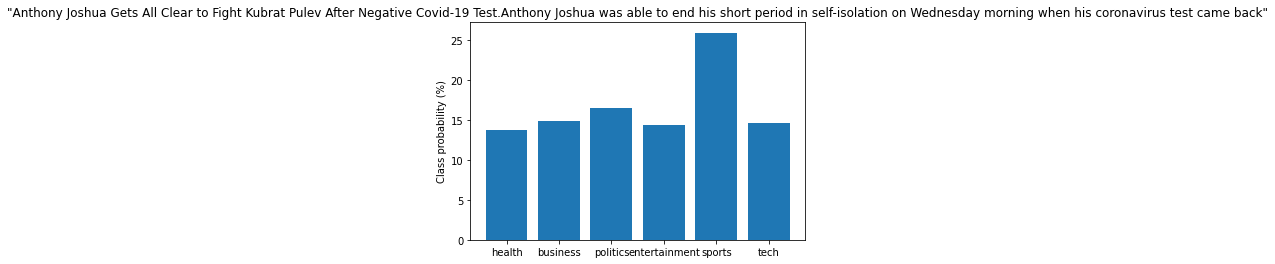

In [76]:
preds = classifier(sample_news, return_all_scores=True)
# visualize results
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{sample_news}"')
plt.ylabel("Class probability (%)")
plt.show()